In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import numpy as np

from utils import remove_outliers

sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 500)

In [2]:
data_col = 'execution_time'
temperature = 45

In [3]:
# timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,cpu_percent,avg_text,avg_data,peak_rss,inputs,outputs,minor_pagefaults,major_pagefaults,swaps,alloc_mem,reclaimed_mem,rts_mem,total_gcs,minor_gcs,major_gcs,avg_mem,max_mem,n_samples,init_cpu,init_sys,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance
data_files = [
    f'../data/results_{temperature}_1.csv',
    f'../data/results_{temperature}_2.csv'
]

df = pd.concat(map(lambda file: pd.read_csv(file), data_files))
df = df.reset_index()
df['total_energy'] = df['pkg_energy'] + df['dram_energy']
display(df)

progs = df['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df['flag'].unique()[1:]
print(f"Flags ({len(flags)}): {flags}")

,index,timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,...,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance,total_energy
0,0,1683221035,circsim,-O2,0,245286.912,1602169.0,52734.0,0.21,0.00,...,0.118,0.118,0.101,0.101,0.093,0.093,0.008,0.008,1,1654903.0
1,1,1683221036,circsim,-O2,0,237353.362,1583614.0,52795.0,0.21,0.00,...,0.118,0.118,0.097,0.098,0.089,0.090,0.008,0.008,1,1636409.0
2,2,1683221042,circsim,-O2,0,238780.570,1529782.0,48157.0,0.19,0.02,...,0.117,0.116,0.097,0.098,0.090,0.090,0.007,0.007,1,1577939.0
3,3,1683221054,circsim,-O2,0,241376.445,1528561.0,48401.0,0.21,0.00,...,0.119,0.118,0.098,0.099,0.090,0.091,0.008,0.008,1,1576962.0
4,4,1683221066,circsim,-O2,0,244602.692,1515926.0,49377.0,0.20,0.02,...,0.120,0.120,0.100,0.100,0.092,0.092,0.008,0.008,1,1565303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19435,9715,1684949622,spectral-norm,-funfolding-use-threshold=160,0,68817.558,469359.0,17517.0,0.04,0.00,...,0.046,0.046,0.000,0.000,0.000,0.000,0.000,0.000,1,486876.0
19436,9716,1684949632,spectral-norm,-funfolding-use-threshold=160,0,74985.504,412231.0,16235.0,0.04,0.00,...,0.049,0.049,0.000,0.000,0.000,0.000,0.000,0.000,1,428466.0
19437,9717,1684949633,spectral-norm,-funfolding-use-threshold=160,0,69123.912,463500.0,16357.0,0.04,0.00,...,0.047,0.047,0.000,0.000,0.000,0.000,0.000,0.000,1,479857.0
19438,9718,1684949634,spectral-norm,-funfolding-use-threshold=160,0,69266.282,469970.0,17700.0,0.04,0.00,...,0.046,0.046,0.000,0.000,0.000,0.000,0.000,0.000,1,487670.0


Programs (18): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin'
 'fannkuch-redux' 'n-body' 'reverse-complement' 'spectral-norm']
Flags (26): ['-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case'
 '-funfolding-use-threshold=40' '-funfolding-use-threshold=160']


In [4]:
def calculate_increase(data, column):
    new_dataframe = []

    for prog in progs:
        base_mean = data[(data['flag'] == '-O2') & (data['program'] == prog)][column].mean()
        
        for flag in flags:
            flag_mean = data[(data['flag'] == flag) & (data['program'] == prog)][column].mean()
            increase = ((flag_mean - base_mean) / base_mean) * 100
            new_dataframe.append([prog, flag, base_mean, flag_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'flag_mean', 'increase'])

In [5]:
df = remove_outliers(df, data_col)
increase_df = calculate_increase(df, data_col)

increase_df['sig'] = [False] * len(increase_df)
increase_df['test'] = [''] * len(increase_df)

Removed 947 outliers


In [6]:
from multiprocessing import Pool
from scipy.stats import ttest_ind
from utils import random_sampling, is_normal

task = [(prog, flag) for prog in progs for flag in flags]

def is_significant(sample):
    prog, flag = sample
    
    base = df[(df['flag'] == '-O2') & (df['program'] == prog)]
    diff = df[(df['flag'] == flag) & (df['program'] == prog)]
    
    base_values = base[data_col].values
    diff_values = diff[data_col].values
    
    if is_normal(base_values) and is_normal(diff_values) and np.var(base_values) != np.var(diff_values):
        _, p = ttest_ind(base_values, diff_values, equal_var=False)
        test = 1
    else:
        p, _, _ = random_sampling(base, diff, data_col, reps=100000, log=False)
        test = 2
        
    return prog, flag, p, test


with Pool() as pool:
    results = pool.map(is_significant, task)

    for prog, flag, pvalue, test in results:
        i = increase_df.index[(increase_df['program'] == prog) & (increase_df['flag'] == flag)].values[0]
        increase_df.at[i, 'sig'] = pvalue < 0.05
        increase_df.at[i, 'test'] = test

increase_df.head(5)

,program,flag,base_mean,flag_mean,increase,sig,test
0,circsim,-fno-case-merge,240549.944538,241537.133050,0.410388,False,2
1,circsim,-fno-case-folding,240549.944538,239469.457875,-0.449174,False,2
2,circsim,-fno-call-arity,240549.944538,239458.573825,-0.453698,False,2
3,circsim,-fno-exitification,240549.944538,238719.308675,-0.761021,True,2
4,circsim,-fno-cmm-elim-common-blocks,240549.944538,237995.251641,-1.062022,True,2


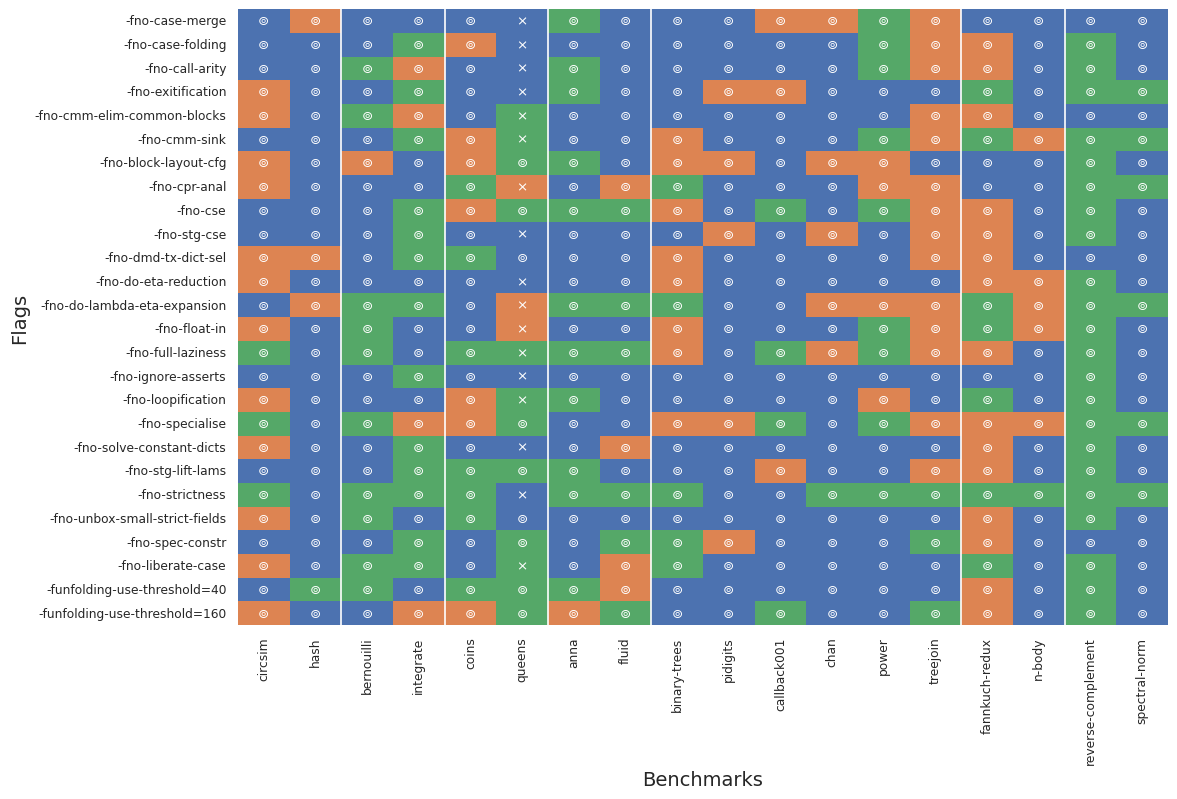

In [7]:
# -1: sig. decrease; 0: no sig. diff.; 1: sig. increase
increase_df['heat'] = np.sign(increase_df['sig'] * increase_df['increase'])

# 1: welch's test; 2: random sampling
labels = increase_df.pivot_table(index=['flag'], columns=['program'], values='test', sort=False)
labels = labels.replace(1, '⨯')
labels = labels.replace(2, '⊚')

plt.figure(figsize=(12,8))
ax = sns.heatmap(
    data = increase_df.pivot_table(index='flag', columns='program', values='heat', sort=False),
    # data = heat_df.pivot_table(index=['flag'], columns=['prog'], values='category'),
    cmap = sns.color_palette(["#dd8452", "#4c72b0", "#55a868"]), # orange, blue, green
    xticklabels=True, yticklabels=True, cbar = False,
    annot= labels,
    fmt= ''
)
ax.set_ylabel("Flags", fontsize=14)
ax.set_xlabel("Benchmarks", fontsize=14)
# ax.xaxis.set_label_coords(0.5, -0.225)
# ax.vlines([3,7,11,17,20,23], *ax.get_xlim(), colors="white")
ax.vlines([2,4,6,8,14,16], *ax.get_ylim(), colors="white")
plt.savefig(f"../charts/{data_col}_{temperature}_stat_heat.pdf", bbox_inches='tight')

# plt.show()

# orange: significant decrease
# blue: no significant difference
# green: significant increase

In [8]:
fno_df = increase_df[(increase_df['flag'] != '-funfolding-use-threshold=40') & (increase_df['flag'] != '-funfolding-use-threshold=160')]
funfolding_df = increase_df[(increase_df['flag'] == '-funfolding-use-threshold=40') & (increase_df['flag'] == '-funfolding-use-threshold=160')]

# increases = len(fno_df[fno_df['heat'] == 1]) + len(funfolding_df[funfolding_df['heat'] == -1])

print(len(fno_df[fno_df['heat'] == 1]))
print(len(fno_df[fno_df['heat'] == 0]))
print(len(fno_df[fno_df['heat'] == -1]))

110
235
87
